In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sdss_tools import sdss_jpg, sdss_fits, sdss_spectra, sdss_template

from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from astroquery.sdss import SDSS

#from astroML.plotting import setup_text_plots
#setup_text_plots(usetex=True,fontsize=18)

%matplotlib inline

##Introduccion

En este tallere aprenderemos a descargar catalogos, imagenes y espectros del Sloan Digital Sky Survey (SDSS). El SDSS es un survey astronómico que cubre gran parte del cielo y que ha producido una gran cantidad de datos de las estrellas y galaxias que habitan en el Universo.

Más info en el link http://www.sdss.org/surveys/
Video del SDSS en https://www.youtube.com/watch?v=UD6cOMpJlZU

El SDSS survey ha permitido que cualquier persona interesada en la Astronomia pueda visitar el sitio web y explorar las imagenes y catalogos del survey. Un ejemplo muy exitoso del uso de los datos del SDSS es el sitio web llamado Galaxy Zoo (https://www.galaxyzoo.org/?lang=es), el cual invitó a la gente de todo el mundo a revisar las galaxias detectadas por el SDSS y clasificarlas morfologicamente

##Parte 1: Conectarse con el servidor y descagar tabla con información de las galaxias del SDSS

Partiremos descargando un catalogo de galaxias elipticas de Galaxy Zoo y analizando los datos. Ejecute el siguiente codigo para descargar los datos

In [8]:
# Ejecute
cat_url='https://raw.githubusercontent.com/rpmunoz/PentaUC/master/Astronomia%20era%20informacion/data/SDSS_galaxyzoo_elipticas.csv'
cat_galaxyzoo=pd.read_csv(cat_url,header=0,sep=',')
cat_galaxyzoo.head()

,ID,ra,dec,votos
0,587736584965390473,217.002375,37.400917,36
1,588015508213727352,41.307375,-0.746111,32
2,587734949668257807,158.403875,11.702222,30
3,587738948284514416,156.077625,37.087222,17
4,587729653425897913,254.959417,33.830361,24


**Ejercicio**

El catalogo de galaxy zoo contiene el ID y las coordenadas de las galaxias clasificadas como elipticas. Además, contiene el número de personas que votaron y clasificaron estas galaxias como elipticas. Haga un histograma que muestre la distribucion del numero de votos y use al menos 10 bines.

¿En torno a que valor se concentra el numero de votaciones?

In [ ]:
# Su codigo y respuesta aqui


Como pueden apreciar, la tabla de galaxy zoo solo contiene coordenadas y votos de las galaxias. ¿Qué sucede con la informacion fotométrica y espectroscópica de estas galaxias? Esta información no se encuentra en el catalogo y es por ello que debemos usar query_region.

Para hacer consultas, lo primero es definir en que coordenadas del cielo estamos buscando un objeto. Para ello se usa la funcion SkyCoord.

In [ ]:
# Ejecute aqui
ra=180.
dec=0.
coo=SkyCoord(ra, dec, unit=(u.deg,u.deg))
print coo

Para hacer una consulta si existe o no un objeto en esa posicion se usa la funcion query_region de astroquery
Ejecute el siguiente codigo

In [ ]:
# Ejecute aqui
result = SDSS.query_region(coo, spectro=True, photoobj_fields=['ra','dec','u','g','r','i','z'], specobj_fields=['z'], radius=2*u.arcsec)
print result

**Pregunta**
¿Cual fue el resultado? ¿Encontramos alguna galaxia en esa posicion?

**Ejercicio**

Complete el siguiente codigo para consultar los datos del primer objeto de nuestra tabla de galaxyzoo. Recuerde que el primer objeto es siempre i=0. ¿Aparece algun valor en la tabla al hacer print result?

In [ ]:
# Complete donde aparecen ...

coo=SkyCoord(cat_galaxyzoo['ra'][...], cat_galaxyzoo['dec'][...], unit=(u.deg,u.deg))

result = SDSS.query_region(coo, spectro=True, photoobj_fields=['ra','dec','u','g','r','i','z'], specobj_fields=['z'], radius=2*u.arcsec)
print result

** Ejercicio **

Ahora haremos la consulta de todos los objetos que estan en nuestro catalogo cat_galaxyzoo. Complete el siguiente codigo. ¿Aparecen los resultados para todas las galaxias? 

In [ ]:
# Complete donde aparecen ...
coo=SkyCoord(cat_galaxyzoo['ra'], cat_galaxyzoo['dec'], unit=(u.deg,u.deg))

#Aqui iremos enviando al servidor la coordenada de la galaxia una por una
for i in range(len(coo)):
    print 'Processing galaxy ', i
    result = SDSS.query_region(coo[i], spectro=True, photoobj_fields=['ra','dec','u','g','r','i','z'], specobj_fields=['z'], radius=2*u.arcsec)
    print result
    if result != None:
        if i==0:
            sdss_data=result[0]
        else:          
            sdss_data.add_row(np.array(result)[0])

print sdss_data

Nuestro nuevo catalogo ya no se muestra de forma tan bonita y aparece como una matriz con muchos numeros. Para arreglarla, usamos la funcion DataFrame de pandas. Ejcute el sigiuiente codigo

In [ ]:
# Ejecute aqui
cat_sdss_elipticas=pd.DataFrame(np.array(sdss_data))
cat_sdss_elipticas.head()

##Parte 2: Conectarse con el servidor y descargar una imagen jpg de la galaxia

Ahor comenzaremos a descargar imagenes jpeg de nuestras galaxias de galaxy zoo. Para ello nos conectaremos al servidor de SDSS y usaremos la funcion sdss_jpg.

El siguiente codigo descargamos la imagen de las priemras dos galaxias

In [ ]:
# Ejecute
sdss_jpg(coo[0:2])

**Ejercicio**

Descague las images jpeg para las primeras 10 imagenes de la lista. ¿Que tipo morfologico son las galaxias?

In [ ]:
# Complete su codigo aqui
sdss_jpg(...)

##Parte 3: Conectarse con el servidor y descargar una imagen FITS de la galaxia

Los astronomos en la vida real no toman imagenes a colores y mas bien toman imagenes en blanco y negro. El tipo de archivo que usamos se llama fits.

Usaremos la funcion sdss_fits para descargar las imagenes de las primeras dos galaxias

In [ ]:
# Ejecute aqui.
# Primero descargamos las imagenes en el filtro g
sdss_fits(coo[0:2], filtro='g')

In [ ]:
# Ejecute aqui
# Ahora descargamos imagenes en el filtro r
sdss_fits(coo[0:2], filtro='r')

**Ejercicio**

Descague las images fits para las primeras 10 imagenes de la lista y use el filtro z. ¿Son iguales o distitnas las imagenes fits y jpeg?

In [ ]:
# Complete el codigo aqui
sdss_fits(...)

##Parte 4: Conectarse con el servidor y descargar el espectro de la galaxia

Ahora comenzaremos a descargar espectros de nuestras galaxias de galaxyzoo. El espectro es la firma que poseen las galaxias.

El siguiente codigo descargamos el espectro de una tipica galaxia eliptica

In [ ]:
sdss_template(tipo='eliptica')

Ahora descargaremos el espectro de las primeras dos galaxias

In [ ]:
#Ejecute aqui
sdss_spectra(coo[0:2], redshift=[0.,0.])

**Ejercicio**

Comience a cambiar los valores de la variable redshift y trate que las lineas de absorción coincidan así como en la funcion sdss_template.

In [ ]:
#Complete aqui donde aparecen los ...
sdss_spectra(coo[0:2], redshift=[...,...])

**Ejercicio**

Ahora descagaremos los espectros para las priemras 10 galaxias. Complete el codigo y determine el redshift de cada una

In [ ]:
#Complete aqui donde aparecen los ...
sdss_spectra(..., redshift=[...])

##Parte 5


### Repita el mismo procedimiento anterior, pero esta vez usando las galaxias espirales

In [11]:
cat_url='https://raw.githubusercontent.com/rpmunoz/PentaUC/master/Astronomia%20era%20informacion/data/SDSS_galaxyzoo_espirales.csv'
cat_galaxyzoo=pd.read_csv(cat_url,header=0,sep=',')
cat_galaxyzoo.head()

,ID,ra,dec,votos
0,587724233176449214,14.559458,15.200250,27
1,588017991768277198,215.539000,9.045556,25
2,588297863121207359,182.168500,46.474806,40
3,587731185652072643,325.864792,-0.480194,27
4,587729386603282615,136.707833,48.772472,43


In [12]:
coo=SkyCoord(cat_galaxyzoo['ra'], cat_galaxyzoo['dec'], unit=(u.deg,u.deg))

for i in range(len(coo)):
    print 'Processing galaxy ', i
    result = SDSS.query_region(coo[i], spectro=True, photoobj_fields=['ra','dec','u','g','r','i','z'], specobj_fields=['z'], radius=2*u.arcsec)
    print result
    if result != None:
        if i==0:
            sdss_data=result
        else:          
            sdss_data.add_row(np.array(result)[0])

cat_sdss_espirales=pd.DataFrame(np.array(sdss_data))
cat_sdss_espirales

Processing galaxy  0
      ra           dec         u        g     ...    i       z         z1    
------------- ------------- -------- -------- ... ------- -------- ----------
14.5594861411 15.2002534257 19.02797 17.08535 ... 15.5504 15.12846 0.05333173
Processing galaxy  1
      ra           dec         u        g     ...    i        z         z1    
------------- ------------- -------- -------- ... -------- -------- ----------
215.539011888 9.04556393197 17.65031 16.11648 ... 14.85882 14.55835 0.09257341
Processing galaxy  2
      ra           dec         u        g     ...    i        z         z1   
------------- ------------- -------- -------- ... -------- -------- ---------
182.168492332 46.4748078549 18.46054 16.63925 ... 15.33657 15.00189 0.1037078
Processing galaxy  3
      ra            dec          u        g     ...    i       z         z1   
------------- --------------- -------- -------- ... ------- -------- ---------
325.864800148 -0.480187831615 19.38846 17.52939 ... 1

,ra,dec,u,g,r,i,z,z1
0,14.559486,15.200253,19.02797,17.08535,16.09030,15.55040,15.12846,0.053332
1,215.539012,9.045564,17.65031,16.11648,15.31245,14.85882,14.55835,0.092573
2,182.168492,46.474808,18.46054,16.63925,15.74723,15.33657,15.00189,0.103708
3,325.864800,-0.480188,19.38846,17.52939,16.56024,16.14820,15.79481,0.119235
4,136.707846,48.772455,16.92475,15.15623,14.36435,13.96674,13.66021,0.051769
5,173.339083,33.433482,19.05486,17.74569,17.23697,16.86767,16.64917,0.044520
6,221.236164,23.149199,19.24344,17.89257,16.84118,16.34900,16.01662,0.206844
7,215.712843,29.873191,17.83310,16.64831,16.28137,16.07171,15.90170,0.039275
8,162.517167,15.450348,17.86082,16.42469,15.71606,15.33343,15.04047,0.074818
9,178.483562,32.643885,18.91358,17.41645,16.73685,16.40557,16.12891,0.071561


Procesando galaxia 1
Procesando galaxia 2


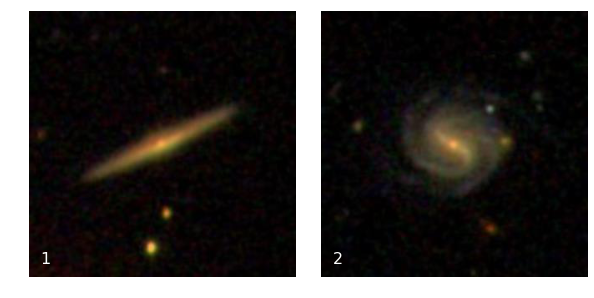

In [13]:
sdss_jpg(coo[0:2])

In [ ]:
sdss_fits(coo[0:2], filtro='g')

In [ ]:
sdss_template(tipo='espiral')

In [ ]:
sdss_spectra(coo[0:2], redshift=[0.,0.])

## Apendices

Descargar el catalogo completo de Galaxy zoo

In [ ]:
import requests, zipfile, StringIO

In [ ]:
cat_url='http://galaxy-zoo-1.s3.amazonaws.com/GalaxyZoo1_DR_table2.csv.zip'

r = requests.get(cat_url)
z = zipfile.ZipFile(StringIO.StringIO(r.content))

cat_file='GalaxyZoo1_DR_table2.csv'
cat_data=pd.read_csv(z.open(cat_file))
cat_data.head()

In [ ]:
cat_data=cat_data.sort_values('P_EL_DEBIASED',ascending=0)
cat_elliptical=cat_data[cat_data['ELLIPTICAL']==1][0:100]
cat_elliptical['ra']=Angle(cat_elliptical['RA'], unit=u.hourangle).degree
cat_elliptical['dec']=Angle(cat_elliptical['DEC'], unit=u.degree).degree
cat_elliptical=cat_elliptical.rename(columns = {'OBJID':'ID','NVOTE':'votos'})
cat_elliptical=cat_elliptical[['ID','ra','dec','votos']].reset_index(drop=True)

cat_elliptical.to_csv('../data/SDSS_galaxyzoo_elipticas.csv',index=False)

In [ ]:
cat_data=cat_data.sort_values('P_CS_DEBIASED',ascending=0)
cat_spiral=cat_data[cat_data['SPIRAL']==1][0:100]
cat_spiral['ra']=Angle(cat_spiral['RA'], unit=u.hourangle).degree
cat_spiral['dec']=Angle(cat_spiral['DEC'], unit=u.degree).degree
cat_spiral=cat_spiral.rename(columns = {'OBJID':'ID','NVOTE':'votos'})
cat_spiral=cat_spiral[['ID','ra','dec','votos']].reset_index(drop=True)

cat_spiral.to_csv('../data/SDSS_galaxyzoo_espirales.csv',index=False)